<a href="https://colab.research.google.com/github/billymoughton94/AI-Curve-Prediction/blob/main/ECS629U_AI_Coursework_Billy_Moughton_170631215.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from torch.utils import data
import matplotlib.pyplot as plt

# 1. Training Sample Generation



*   2000 functions modeled
*   Each containing 40 ***x*** points and corresponding ***y = f(x)*** points



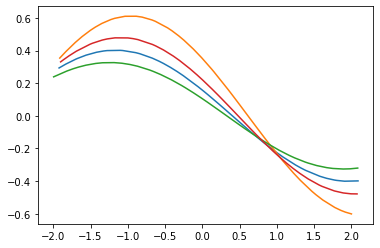

In [ ]:
Nf = 2000       # number of functions
Npts = 40       # number of x points in each function
x = torch.zeros(Nf, Npts, 1)
for k in range(Nf):
    x[k,:,0] = torch.linspace(-2, 2, Npts)

x += torch.rand_like(x)*0.1
a = -2 + 4*torch.rand(Nf).view(-1,1).repeat(1, Npts).unsqueeze(2)
y = a * torch.sin(x + a)  # y value for each f(x)
plt.plot(x[0, :], y[0, :])
plt.plot(x[1, :], y[1, :])
plt.plot(x[2, :], y[2, :])
plt.plot(x[3, :], y[3, :])

# 2. Dataset and DataLoader initialization


*   DataLoader created to hold ***x*** and ***y*** values for every function
*   Training DataLoader created on the DataLoader, with a provided batch size of 16 and shuffle set to True
  *   16 random samples (functions) fed to the models at a time


In [ ]:
dataset = data.TensorDataset(x, y)    # dataset containing the x and y values for all 2000 functions
batch_size = 16      # the number of samples which will appear in each batch iteration                   
train_iter = data.DataLoader(dataset, batch_size, shuffle = True)   # assigns random samples to batches and allows iteration through them

# 3. Encoder MLP

*   Will take an ***Nc*** number of of ***(Xc, Yc)*** context pairs per batch -> a randomly sliced set of ***(X, Y)*** pairs in the current batch set
*   Encoder will predict the function used to generate the correpsonding ***Yc*** for each ***Xc*** for each sample in the batch set: a vector ***r_c*** of dimension ***r_dim*** 
*   An average for each sample will be taken from ***r_c*** to produce ***RC***: representing the average function used in the sample, used as input to the Decoder



In [ ]:
class Encoder_MLP(torch.nn.Module):
  def __init__(self, num_inputs, num_hidden, num_outputs): # inputs: (Xc, Yc) pairs, outputs: RC function prediction for each sample
    super(Encoder_MLP, self).__init__()
    self.num_inputs = num_inputs
    self.num_hidden = num_hidden
    self.num_outputs = num_outputs
    self.Lin1 = nn.Linear(self.num_inputs, self.num_hidden)
    self.Act1 = nn.Sigmoid()    # activation function allows for non-linearity
    self.Lin2 = nn.Linear(self.num_hidden, self.num_outputs)

  def forward(self, x):
    x = self.Lin1(x) # hidden layer
    x = self.Act1(x) # activation
    x = self.Lin2(x) # output layer
    return torch.mean(x, 1, True) # averages the r_c values to get RC

# 4. Decoder MLP

*   Will take the entire ***X*** tensor, concatenated with ***RC*** as inputs
*   Using the predicted function RC for each row, the Decoder predicts ***Y_hat*** for each ***X*** in each sample



In [ ]:
class Decoder_MLP(torch.nn.Module):
  def __init__(self, num_inputs, num_hidden, num_outputs): # inputs: (Xt, RC) pairs, outputs: y_pred prediction for each x in each sample
    super(Decoder_MLP, self).__init__()
    self.num_inputs = num_inputs
    self.num_hidden = num_hidden
    self.num_outputs = num_outputs
    self.Lin1 = nn.Linear(self.num_inputs, self.num_hidden)
    self.Act1 = nn.Sigmoid()    # activation function allows for non-linearity
    self.Lin2 = nn.Linear(self.num_hidden, self.num_outputs)

  def forward(self, x):
    x = self.Lin1(x) # hidden layer
    x = self.Act1(x) # activation
    x = self.Lin2(x) # output layer
    return x    # y_pred

#  5. MLP Initialisation

*   Instances created for Encoder and Decoder models, each containing number of input layer neurons, number of hidden layer neurons and number of output layer neurons
*   Number of output neurons for the Encoder reflects the ***r_dim*** of ***RC***, which means the Decoder must have +1 input size (to account for the concatenated ***X*** tensor)
*   Weights and biases of both models are initialized using helper function *init_weights()*
*   A normal distribution will be provided for the weights, with biases set to 0
*   Mean Squared Error loss function is created which will be used for back propagation later when adjusting the model parameters
*   Two AdamW optimizers are created for each MLP. Customized rates and weight decay set for both.

In [ ]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight, mean = 0, std = 0.01) # provides model weights a Guassian distribution
        torch.nn.init.zeros_(m.bias)    # initiliases model biases to be 0

In [ ]:
my_Encoder = Encoder_MLP(2, 40, 8)
my_Decoder = Decoder_MLP(9, 30, 1)
my_Encoder.apply(init_weights)
my_Decoder.apply(init_weights)
my_loss = nn.MSELoss()    # loss function which will help find gradients for parameter adjustment
encoder_opt = torch.optim.AdamW(params = my_Encoder.parameters(), lr = 0.03, weight_decay = 0.0004) # optimzers which will impove the model as training progresses
decoder_opt = torch.optim.AdamW(params = my_Decoder.parameters(), lr = 0.004, weight_decay = 0.0004)

# 6. Context Pair Selection
*    Helper function which will randomly sample ***Nc*** different ***(X, Y)*** pairs for each batch

In [ ]:
import random
def generateContexts(X, Y, width):
  numCtx = random.randint(1, width)   # select a random number of (x,y) points between 1 and width (40 for the training set)
  contextSet = torch.Tensor(len(X), numCtx, 2)  # create the skeleton for the (Xc, Yc) context set
  for i in range(numCtx):
    indice = random.randint(0, width - 1)   # pick a random (X,Y) pair to use
    contextSet[:, i, 0] = X[:, indice, 0]
    contextSet[:, i, 1] = Y[:, indice, 0]
  return contextSet

# 7. Model training

*   For a given number of epochs, the entire training set will be modelled against. Once per epoch
*   For each epoch, the DataLoader iterates through the batches and runs them through the two MLPs
*   After getting output ***y_hat***, the loss function calculates how far off ***y_hat*** values are from ***Y*** and computes the gradients representing the direction of adjustment for each parameter in the Encoder and Decoder
*   Process repeats until all epochs have been covered, by which point the Models should have been optimized



Loss at epoch 1: 0.418
Loss at epoch 2: 0.3604
Loss at epoch 3: 0.356
Loss at epoch 4: 0.3572
Loss at epoch 5: 0.3535
Loss at epoch 6: 0.3503
Loss at epoch 7: 0.3074
Loss at epoch 8: 0.1894
Loss at epoch 9: 0.1393
Loss at epoch 10: 0.1036
Loss at epoch 11: 0.097
Loss at epoch 12: 0.0735
Loss at epoch 13: 0.0712
Loss at epoch 14: 0.0687
Loss at epoch 15: 0.0534
Loss at epoch 16: 0.0723
Loss at epoch 17: 0.0631
Loss at epoch 18: 0.0371
Loss at epoch 19: 0.0404
Loss at epoch 20: 0.0469
Loss at epoch 21: 0.0431
Loss at epoch 22: 0.0311
Loss at epoch 23: 0.0405
Loss at epoch 24: 0.0214
Loss at epoch 25: 0.0256
Loss at epoch 26: 0.0271
Loss at epoch 27: 0.0223
Loss at epoch 28: 0.0275
Loss at epoch 29: 0.0227
Loss at epoch 30: 0.0281
Loss at epoch 31: 0.0107
Loss at epoch 32: 0.0315
Loss at epoch 33: 0.0246
Loss at epoch 34: 0.0278
Loss at epoch 35: 0.0192
Loss at epoch 36: 0.0165
Loss at epoch 37: 0.0315
Loss at epoch 38: 0.0164
Loss at epoch 39: 0.015
Loss at epoch 40: 0.0236
Loss at epoch

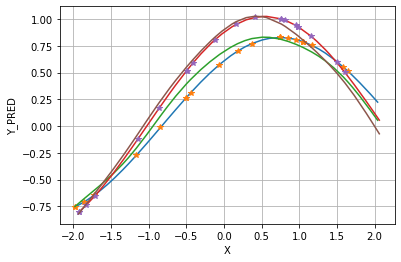

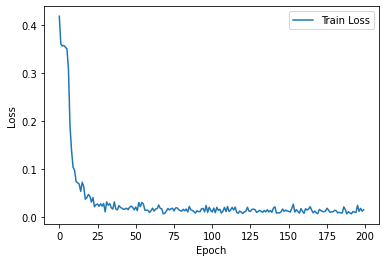

In [ ]:
def train(my_Encoder, my_Decoder, train_iter, loss, encoder_opt, decoder_opt, epochs):
  my_Encoder.train() # sets both MLPs to train mode
  my_Decoder.train()
  epoch_losses = [] # used for plotting the losses of epochs later on
  for epoch in range(epochs): # loops through each epoch
    running_loss = [] # keeps track of the total accumulated loss in the current epoch
    for X, Y in train_iter: # loops through each batch, placing that batch's X,Y pairs in the respective variables
      encoder_opt.zero_grad() # gradients must be reset from the previous iteration to calculate how much to adjust the weights for this iteration
      decoder_opt.zero_grad()
      enc_input = generateContexts(X, Y, 40)  # generate the (Xc, Yc) context pairs for this batch
      RC = my_Encoder(enc_input)    # obtains the predicted functions RC from the Encoder
      RC = torch.repeat_interleave(RC, len(X[0]), 1) # repeats the RC values so that it may be concatenated with Xt
      dec_input = torch.cat((RC, X), 2) # joins RC with Xt as input for Decoder
      y_hat = my_Decoder(dec_input) # obtains predicted y values for each x in the batch
      loss = my_loss(y_hat, Y)  # finds the difference between actual and predicted y values
      loss.backward()   # using the loss, back propagates to find the degree and direction to which each parameter must be adjusted
      encoder_opt.step() # adjusts the Encoder and Decoder parameters using the gradients obtained from back propagation
      decoder_opt.step()

      running_loss.append(loss.item())  # loss for this batch is added to the running total for this epoch
    epoch_losses.append(sum(running_loss) / len(running_loss)) # calculates the average loss in this epoch
    print('Loss at epoch {0}: {1}'.format(epoch + 1, round(sum(running_loss) / len(running_loss), 4)))
  print('Average loss: {0}' .format(sum(epoch_losses) / len(epoch_losses)))
  print('Final epoch loss: {0}' .format(epoch_losses[-1]))
 
  with torch.no_grad(): # training output examples and epoch loss are plotted
    plt.figure()
    plt.subplot(111)
    plt.grid()

    plt.plot(X[0, :, 0], Y[0, :, 0])
    plt.plot(enc_input[0, :, 0], enc_input[0, :, 1], '*')
    plt.plot(X[0, :, 0], y_hat[0, :].detach())

    plt.plot(X[1, :, 0], Y[1, :, 0])
    plt.plot(enc_input[1, :, 0], enc_input[1, :, 1], '*')
    plt.plot(X[1, :, 0], y_hat[1, :].detach())
  
    plt.xlabel("X")
    plt.ylabel("Y_PRED")

    plt.figure()
    plt.subplot(111)
    plt.plot(epoch_losses, label = "Train Loss")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    return epoch_losses

train_losses = train(my_Encoder, my_Decoder, train_iter, my_loss, encoder_opt, decoder_opt, 200) # begins training

# 8. Model Testing


*   Having trained the model, another test dataset is created, using 500 functions.
*   Will be the final evaluation of the models

In [ ]:
def test(my_Encoder, my_Decoder, test_iter, epochs): # same format as training function, except optimization is not performed
  my_Encoder.eval() # evaluation mode is now active
  my_Decoder.eval()
  epoch_losses = []
  for epoch in range(epochs):
    running_loss = []
    for x, y in test_iter:
      RC = my_Encoder(generateContexts(x, y, x.shape[1]))
      RC = torch.repeat_interleave(RC, len(x[0]), 1)
      dec = torch.cat((RC, x), 2)
      y_hat = my_Decoder(dec)
      loss = my_loss(y, y_hat)
      running_loss.append(loss.item())
    epoch_losses.append(sum(running_loss) / len(running_loss))
    print('Loss at epoch {0}: {1}'.format(epoch + 1, round(sum(running_loss) / len(running_loss), 4)))

  print('Average loss: {0}' .format(sum(epoch_losses) / len(epoch_losses)))
  print('Final epoch loss: {0}' .format(epoch_losses[-1]))
  return epoch_losses

In [ ]:
# Test sample used for training. Same format as original function generator with less samples
Nf = 500
Npts = 40
x = torch.zeros(Nf, Npts, 1)
for k in range(Nf):
    x[k,:,0] = torch.linspace(-2, 2, Npts)
x += torch.rand_like(x)*0.1
a = -2 + 4*torch.rand(Nf).view(-1,1).repeat(1, Npts).unsqueeze(2)
y = a * torch.sin(x + a)

dataset = data.TensorDataset(x, y)
batch_size = 16
test_iter = data.DataLoader(dataset, batch_size, shuffle = True)

test_losses = test(my_Encoder, my_Decoder, test_iter, 200) # begins testing

Loss at epoch 1: 0.012
Loss at epoch 2: 0.0074
Loss at epoch 3: 0.0061
Loss at epoch 4: 0.0089
Loss at epoch 5: 0.004
Loss at epoch 6: 0.0172
Loss at epoch 7: 0.0057
Loss at epoch 8: 0.0138
Loss at epoch 9: 0.0196
Loss at epoch 10: 0.0152
Loss at epoch 11: 0.0166
Loss at epoch 12: 0.0181
Loss at epoch 13: 0.0196
Loss at epoch 14: 0.015
Loss at epoch 15: 0.0121
Loss at epoch 16: 0.01
Loss at epoch 17: 0.0063
Loss at epoch 18: 0.005
Loss at epoch 19: 0.0064
Loss at epoch 20: 0.0125
Loss at epoch 21: 0.0209
Loss at epoch 22: 0.0226
Loss at epoch 23: 0.005
Loss at epoch 24: 0.0067
Loss at epoch 25: 0.0081
Loss at epoch 26: 0.0072
Loss at epoch 27: 0.0131
Loss at epoch 28: 0.0102
Loss at epoch 29: 0.0088
Loss at epoch 30: 0.0097
Loss at epoch 31: 0.0314
Loss at epoch 32: 0.0045
Loss at epoch 33: 0.0083
Loss at epoch 34: 0.0099
Loss at epoch 35: 0.0087
Loss at epoch 36: 0.0142
Loss at epoch 37: 0.0174
Loss at epoch 38: 0.0078
Loss at epoch 39: 0.0131
Loss at epoch 40: 0.0051
Loss at epoch 41

# 9. Training and Test Loss

*   Plots the training loss against the test loss

Text(0, 0.5, 'Loss')

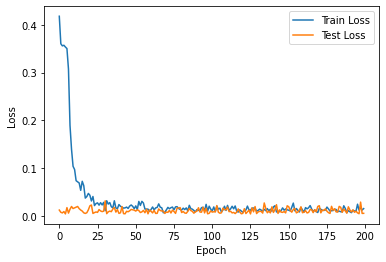

In [ ]:
# Plots the returned epoch loss arrays from training and testing. Used to compare performance on both
plt.figure()
plt.subplot(111)
plt.plot(train_losses, label = "Train Loss")
plt.plot(test_losses, label = "Test Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

# 10. Results from the 6 Functions

Mounted at /content/gdrive


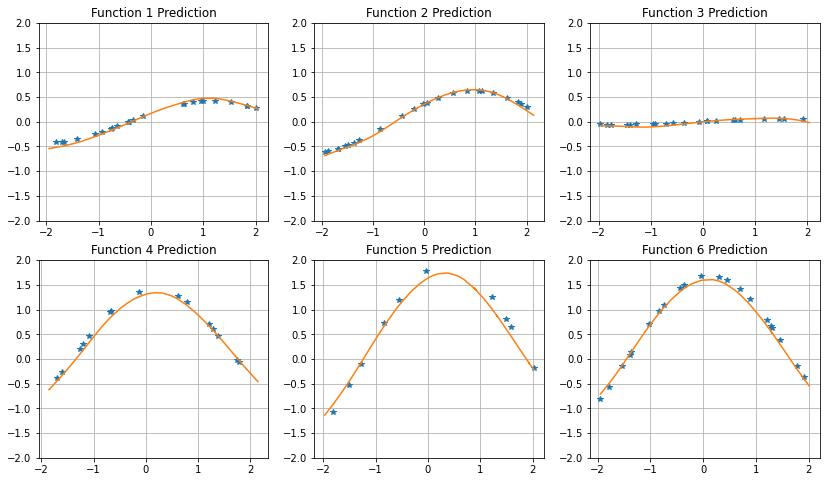

In [ ]:
# Testing on the 6 provided functions
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) #mount google drive
import pickle
path_to_the_pickle = '/content/gdrive/MyDrive/Colab Notebooks/test_data.pkl'
test_data =pickle.load(open(path_to_the_pickle,'rb'))

plt.figure(figsize = (14, 8))
for i in range(6):
  # 6 test functions
  name= 'function_num_{}'.format(i +1)
  x_c=test_data[name]['context_pairs'][0]
  y_c=test_data[name]['context_pairs'][1]
  x_t =test_data[name]['x']
  RC = my_Encoder(torch.cat((x_c, y_c), 2))
  RC = torch.repeat_interleave(RC, len(x[0]), 1)
  dec = torch.cat((RC, x_t), 2)
  y_pred = my_Decoder(dec)


  plt.subplot(2, 3, i+1)
  plt.ylim(-2, 2)
  plt.grid()
  plt.plot(x_c[0, :, 0], y_c[0, :, 0], '*')
  plt.plot(x_t[0, :, 0], y_pred[0, :, 0].detach().numpy())
  plt.title("Function {0} Prediction" .format(i +1))